# Understanding Deep Deterministic Policy Gradient (DDPG): A Complete Guide

# Table of Contents

- [Introduction](#introduction)
- [What is DDPG?](#what-is-ddpg)
  - [Key Ideas: Deterministic Policy & Off-Policy Learning](#key-ideas)
- [Where and How DDPG is Used](#where-and-how-ddpg-is-used)
- [Mathematical Foundation of DDPG](#mathematical-foundation-of-ddpg)
  - [Actor-Critic Framework Recap](#actor-critic-framework-recap)
  - [Deterministic Policy Gradient Theorem](#deterministic-policy-gradient-theorem)
  - [Critic (Q-Network) Update](#critic-q-network-update)
  - [Actor (Policy Network) Update](#actor-policy-network-update)
  - [Target Networks and Soft Updates](#target-networks-and-soft-updates)
  - [Exploration Noise](#exploration-noise)
- [Step-by-Step Explanation of DDPG](#step-by-step-explanation-of-ddpg)
- [Key Components of DDPG](#key-components-of-ddpg)
  - [Actor Network (Deterministic Policy)](#actor-network-deterministic-policy)
  - [Critic Network (Q-Value Function)](#critic-network-q-value-function)
  - [Target Actor & Target Critic Networks](#target-actor--target-critic-networks)
  - [Replay Buffer](#replay-buffer)
  - [Exploration Noise Process](#exploration-noise-process)
  - [Soft Target Updates](#soft-target-updates)
  - [Hyperparameters](#hyperparameters)
- [Practical Example: Pendulum Environment](#practical-example-pendulum-environment)
  - [Why Pendulum? (Continuous Actions)](#why-pendulum-continuous-actions)
- [Setting up the Environment](#setting-up-the-environment)
- [Creating the Continuous Environment (Gymnasium)](#creating-the-continuous-environment-gymnasium)
- [Implementing the DDPG Algorithm](#implementing-the-ddpg-algorithm)
  - [Defining the Actor Network](#defining-the-actor-network)
  - [Defining the Critic Network](#defining-the-critic-network)
  - [Defining the Replay Memory](#defining-the-replay-memory)
  - [Defining the Exploration Noise](#defining-the-exploration-noise)
  - [Soft Update Function](#soft-update-function)
  - [The DDPG Update Step](#the-ddpg-update-step)
- [Running the DDPG Algorithm](#running-the-ddpg-algorithm)
  - [Hyperparameter Setup](#hyperparameter-setup)
  - [Initialization](#initialization)
  - [Training Loop](#training-loop)
- [Visualizing the Learning Process](#visualizing-the-learning-process)
- [Analyzing the Learned Policy (Testing)](#analyzing-the-learned-policy-testing)
- [Common Challenges and Solutions in DDPG](#common-challenges-and-solutions-in-ddpg)
- [Conclusion](#conclusion)

## Introduction

Deep Deterministic Policy Gradient (DDPG) is an **off-policy actor-critic** algorithm designed specifically for environments with **continuous action spaces**. It combines ideas from Deep Q-Networks (DQN) like replay buffers and target networks with the actor-critic framework and adapts policy gradients for deterministic policies. This makes it a powerful tool for tasks like robotic control and simulated physics environments where actions are real-valued.

## What is DDPG?

DDPG learns two primary networks:

1.  **Actor ($\mu(s; \theta^\mu)$):** A policy network that takes a state $s$ and outputs a *specific, deterministic* action $a = \mu(s)$, rather than a probability distribution over actions. Parameterized by $\theta^\mu$.
2.  **Critic ($Q(s, a; \theta^Q)$):** A Q-value network that takes a state $s$ and an action $a$ and outputs the estimated Q-value (expected return) for that state-action pair. Parameterized by $\theta^Q$.

It uses techniques inspired by DQN to stabilize learning:
- **Replay Buffer:** Stores experiences $(s_t, a_t, r_t, s_{t+1})$ and samples mini-batches for updates, enabling off-policy learning and breaking data correlations.
- **Target Networks:** Maintains separate target networks for both the actor ($\mu'$) and the critic ($Q'$), which are updated slowly (soft updates) towards the main networks. This provides stable targets for the critic's learning.

### Key Ideas: Deterministic Policy & Off-Policy Learning

- **Deterministic Policy:** Directly outputting an action simplifies learning in continuous spaces compared to parameterizing a complex continuous probability distribution. However, it necessitates adding explicit exploration noise.
- **Off-Policy:** Using a replay buffer allows DDPG to reuse past experiences generated by older policies, making it significantly more sample-efficient than on-policy methods like REINFORCE, A2C, or TRPO/PPO, especially when environment interaction is expensive.

## Where and How DDPG is Used

DDPG is primarily used for problems with continuous action spaces:

1.  **Robotics:** Learning control policies for robotic arms, locomotion, manipulation.
2.  **Continuous Control Benchmarks:** Tasks like Pendulum, MountainCarContinuous, MuJoCo environments (Hopper, Walker, etc.).
3.  **Autonomous Driving (Simulation):** Controlling steering, acceleration.

DDPG is suitable when:
- The action space is continuous.
- Sample efficiency is important (off-policy learning helps).
- A deterministic policy is acceptable or desired.

However, DDPG can be sensitive to hyperparameters and sometimes suffers from Q-value overestimation and instability. Extensions like TD3 (Twin Delayed DDPG) were developed to address these issues.

## Mathematical Foundation of DDPG

### Actor-Critic Framework Recap
The core idea remains: the Critic evaluates state-action values, and the Actor updates its policy based on the Critic's evaluation.

### Deterministic Policy Gradient Theorem
For a deterministic policy $a = \mu(s; \theta^\mu)$, the gradient of the performance objective $J(\theta^\mu)$ is given by:
$$ \nabla_{\theta^\mu} J(\theta^\mu) = \mathbb{E}_{s \sim \rho^beta} [ \nabla_{\theta^\mu} \mu(s; \theta^\mu) \nabla_a Q(s, a; \theta^Q)|_{a=\mu(s; \theta^\mu)} ] $$
where $\rho^beta$ is the state distribution under some exploration policy $beta$. Since DDPG is off-policy and uses a replay buffer, the expectation is taken over states sampled from the buffer.
Intuitively, the actor's parameters $\theta^\mu$ are updated in the direction that increases the Q-value predicted by the critic for the action chosen by the actor.

### Critic (Q-Network) Update
The critic $Q(s, a; \theta^Q)$ is updated similarly to DQN, using samples $(s_i, a_i, r_i, s_{i+1})$ from the replay buffer. It minimizes the Mean Squared Bellman Error (MSBE):
$$ L(\theta^Q) = \mathbb{E}_{(s,a,r,s') \sim \mathcal{D}} [ (y - Q(s, a; \theta^Q))^2 ] $$
The target value $y$ is computed using the *target* actor ($\mu'$) and *target* critic ($Q'$):
$$ y = r + \gamma Q'(s', \mu'(s'; \theta^{\mu'}) ; \theta^{Q'}) $$
Using target networks provides stability by decoupling the target calculation from the parameters being currently updated.

### Actor (Policy Network) Update
The actor $\mu(s; \theta^\mu)$ is updated by maximizing the expected output of the *main critic* $Q$ with respect to the actor's parameters. This is achieved by gradient ascent on:
$$ J(\theta^\mu) \approx \mathbb{E}_{s \sim \mathcal{D}} [ Q(s, \mu(s; \theta^\mu) ; \theta^Q) ] $$
In practice, this means taking the gradient of the critic's output (evaluated with the actor's action) with respect to the actor's parameters. Using PyTorch's autograd, this can be achieved by computing the loss $L(\theta^\mu) = -\frac{1}{N} \sum_i Q(s_i, \mu(s_i; \theta^\mu) ; \theta^Q)$ and performing gradient descent.

### Target Networks and Soft Updates
To stabilize learning, DDPG uses target networks $Q'(s, a; \theta^{Q'})$ and $\mu'(s; \theta^{\mu'})$ with parameters $\theta^{Q'}$ and $\theta^{\mu'}$. These are not trained directly but are updated slowly towards the main network parameters ($	heta^Q, \theta^\mu$) after each update step using "soft" updates:
$$ \theta' \leftarrow \tau \theta + (1 - \tau) \theta' $$
where $\tau \ll 1$ (e.g., 0.001, 0.005) is the soft update rate. This makes the target values $y$ change slowly, improving stability.

### Exploration Noise
Since the actor policy is deterministic, exploration must be added externally during training rollouts. A common approach is to add noise to the actor's output action before executing it in the environment:
$$ a_t = \mu(s_t; \theta^\mu) + \mathcal{N}_t $$
where $\mathcal{N}_t$ is a noise process (e.g., Ornstein-Uhlenbeck process for temporally correlated noise, or simpler Gaussian noise). The noise level is often annealed over time.

## Step-by-Step Explanation of DDPG

1.  **Initialize**: Actor network $\mu(s; \theta^\mu)$, Critic network $Q(s, a; \theta^Q)$.
2.  **Initialize**: Target networks $\mu'(s; \theta^{\mu'})$ and $Q'(s, a; \theta^{Q'})$ with $\theta^{\mu'} \leftarrow \theta^\mu$, $\theta^{Q'} \leftarrow \theta^Q$.
3.  **Initialize**: Replay buffer $\mathcal{D}$, noise process $\mathcal{N}$.
4.  **For each episode**:
    a.  Reset environment, get initial state $s_0$. Reset noise process.
    b.  **For each step $t$**:
        i.   Select action $a_t = \mu(s_t; \theta^\mu) + \mathcal{N}_t$. Clip action if necessary to fit environment bounds.
        ii.  Execute $a_t$, observe reward $r_t$, next state $s_{t+1}$, done flag $d_t$.
        iii. Store transition $(s_t, a_t, r_t, s_{t+1}, d_t)$ in $\mathcal{D}$.
        iv.  **Sample mini-batch**: Get random batch of $N$ transitions from $\mathcal{D}$.
        v.   **Calculate Critic Target**: For each sample $j$ in batch:
             $a'_{j+1} = \mu'(s_{j+1}; \theta^{\mu'})$
             $y_j = r_j + \gamma (1-d_j) Q'(s_{j+1}, a'_{j+1} ; \theta^{Q'})$
        vi.  **Update Critic**: Minimize loss $L = \frac{1}{N} \sum_j (y_j - Q(s_j, a_j; \theta^Q))^2$ via gradient descent.
        vii. **Update Actor**: Maximize objective (or minimize negative objective) $J = \frac{1}{N} \sum_j Q(s_j, \mu(s_j; \theta^\mu); \theta^Q)$ using gradient ascent (or descent on $-J$). Note: Gradients flow from critic output back through the actor.
        viii.**Update Target Networks**: Perform soft updates:
             $\theta^{Q'} \leftarrow \tau \theta^Q + (1 - \tau) \theta^{Q'}$
             $\theta^{\mu'} \leftarrow \tau \theta^\mu + (1 - \tau) \theta^{\mu'}$
        ix.  $s_t \leftarrow s_{t+1}$.
        x.   If $d_t$, break episode.
5.  **Repeat**: Until convergence or max episodes.

## Key Components of DDPG

### Actor Network (Deterministic Policy)
- Maps state $s$ to a specific continuous action $a = \mu(s)$.
- Trained to output actions that maximize the Q-value estimated by the critic.
- Often uses `tanh` activation on the output layer, scaled to match action bounds.

### Critic Network (Q-Value Function)
- Estimates the value $Q(s, a)$ of taking action $a$ in state $s$.
- Takes both state and action as input.
- Trained using Bellman equation targets derived from target networks.

### Target Actor & Target Critic Networks
- Separate copies of the actor and critic networks used for calculating stable target values ($y$) for the critic update.
- Updated slowly via soft updates.

### Replay Buffer
- Stores $(s, a, r, s', done)$ transitions.
- Allows off-policy learning and breaks data correlations by sampling random mini-batches.

### Exploration Noise Process
- Added to the deterministic actor's output during training rollouts to encourage exploration.
- Examples: Ornstein-Uhlenbeck (correlated noise), Gaussian noise. Often annealed over time.

### Soft Target Updates
- Slowly blends the main network parameters into the target network parameters using rate $\tau$.
- Key for stability compared to infrequent hard updates.

### Hyperparameters
- Replay buffer size, batch size.
- Learning rates for actor ($\alpha_\mu$) and critic ($\alpha_Q$).
- Target network soft update rate ($	au$).
- Discount factor ($\gamma$).
- Exploration noise parameters (type, scale, annealing).
- Network architectures.

## Practical Example: Pendulum Environment

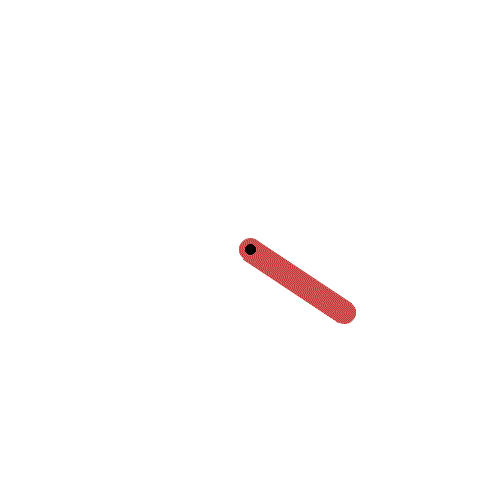

### Why Pendulum? (Continuous Actions)
DDPG is designed for environments where the agent must output continuous values (like applying a specific torque, setting a velocity, or positioning a robotic arm joint). The Grid World has discrete actions (Up, Down, Left, Right). The `Pendulum-v1` environment is a standard benchmark with:
- **Continuous State:** `[cos(theta), sin(theta), theta_dot]`
- **Continuous Action:** Torque applied to the joint, a single value usually between [-2.0, 2.0].

Using this environment allows us to correctly demonstrate DDPG's handling of continuous actions. **This requires the `gymnasium` library, deviating slightly from the 'basic libraries only' constraint of the reference DQN notebook, as DDPG is fundamentally suited for such environments.**

# Setting up the Environment

Import libraries, including `gymnasium`.

In [1]:
# Import necessary libraries
import numpy as np
import matplotlib.pyplot as plt
import random
import math
from collections import namedtuple, deque
from itertools import count
from typing import List, Tuple, Dict, Optional, Callable, Any, Union
import copy
import os
import time

# Import PyTorch
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

# Import Gymnasium for the continuous environment
try:
    import gymnasium as gym
except ImportError:
    print("Gymnasium not found. Please install using 'pip install gymnasium' or 'pip install gym[classic_control]'" )
    # You might want to exit or raise an error here if gym is essential
    gym = None # Set gym to None if import fails

# Set up device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Set random seeds for reproducibility
seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(seed)

%matplotlib inline

Using device: cpu


# Creating the Continuous Environment (Gymnasium)

Instantiate the Pendulum environment using Gymnasium.

In [2]:
# Instantiate the Pendulum environment
if gym is not None:
    try:
        # Create the environment
        env = gym.make('Pendulum-v1')
        
        # Set seeds for environment reproducibility
        env.reset(seed=seed)
        env.action_space.seed(seed)

        # Get state and action space dimensions
        n_observations_ddpg = env.observation_space.shape[0]
        n_actions_ddpg = env.action_space.shape[0] # DDPG handles continuous actions
        action_low = env.action_space.low[0]
        action_high = env.action_space.high[0]

        print(f"Pendulum Environment:")
        print(f"State Dim: {n_observations_ddpg}")
        print(f"Action Dim: {n_actions_ddpg}")
        print(f"Action Low: {action_low}")
        print(f"Action High: {action_high}")
        
        # Test reset
        obs, info = env.reset()
        print(f"Initial observation: {obs}")
        
    except Exception as e:
        print(f"Error creating Gymnasium environment: {e}")
        # Set dummy values if env creation fails
        n_observations_ddpg = 3
        n_actions_ddpg = 1
        action_low = -2.0
        action_high = 2.0
        env = None # Mark env as unusable
else:
    print("Gymnasium not available. Cannot create Pendulum environment.")
    # Set dummy values
    n_observations_ddpg = 3
    n_actions_ddpg = 1
    action_low = -2.0
    action_high = 2.0
    env = None

Pendulum Environment:
State Dim: 3
Action Dim: 1
Action Low: -2.0
Action High: 2.0
Initial observation: [-0.6306115   0.77609867  0.39473605]


# Implementing the DDPG Algorithm

Define the Actor, Critic, Replay Buffer, Noise, and update logic.

### Defining the Actor Network

Outputs a deterministic continuous action, scaled by `tanh` and the environment's action bounds.

In [3]:
class ActorNetwork(nn.Module):
    """ Deterministic Actor Network for DDPG """
    def __init__(self, n_observations: int, n_actions: int, action_high_bound: float):
        super(ActorNetwork, self).__init__()
        self.action_high_bound = action_high_bound
        # Simple MLP architecture
        self.layer1 = nn.Linear(n_observations, 256)
        self.layer2 = nn.Linear(256, 256)
        self.layer3 = nn.Linear(256, n_actions)
        
        # Initialize final layer weights for smaller initial outputs
        # Often helps in DDPG
        nn.init.uniform_(self.layer3.weight, -3e-3, 3e-3)
        nn.init.uniform_(self.layer3.bias, -3e-3, 3e-3)

    def forward(self, state: torch.Tensor) -> torch.Tensor:
        """
        Maps state to a deterministic action.
        Parameters:
        - state (torch.Tensor): Input state tensor.
        Returns:
        - torch.Tensor: The deterministic action, scaled to environment bounds.
        """
        x = F.relu(self.layer1(state))
        x = F.relu(self.layer2(x))
        # Use tanh to bound output between -1 and 1
        action_tanh = torch.tanh(self.layer3(x))
        # Scale to the environment's action bounds
        scaled_action = action_tanh * self.action_high_bound
        return scaled_action

### Defining the Critic Network

Outputs a Q-value given state and action. Action is typically concatenated after initial state processing.

In [4]:
class CriticNetwork(nn.Module):
    """ Q-Value Critic Network for DDPG """
    def __init__(self, n_observations: int, n_actions: int):
        super(CriticNetwork, self).__init__()
        # Process state separately first
        self.state_layer1 = nn.Linear(n_observations, 256)
        # Combine state features and action in the second layer
        self.combined_layer2 = nn.Linear(256 + n_actions, 256)
        self.output_layer3 = nn.Linear(256, 1)

    def forward(self, state: torch.Tensor, action: torch.Tensor) -> torch.Tensor:
        """
        Maps state and action to a Q-value.
        Parameters:
        - state (torch.Tensor): Input state tensor.
        - action (torch.Tensor): Input action tensor.
        Returns:
        - torch.Tensor: The estimated Q(s, a) value.
        """
        state_features = F.relu(self.state_layer1(state))
        # Concatenate state features and action
        combined = torch.cat([state_features, action], dim=1)
        x = F.relu(self.combined_layer2(combined))
        q_value = self.output_layer3(x)
        return q_value

### Defining the Replay Memory

Standard replay buffer implementation, similar to DQN.

In [5]:
# Define the structure for storing transitions
Transition = namedtuple('Transition',
                        ('state', 'action', 'reward', 'next_state', 'done'))

# Define the Replay Memory class
class ReplayMemory(object):
    """ Stores transitions and allows sampling batches. """
    def __init__(self, capacity: int):
        """
        Initialize the Replay Memory.
        Parameters:
        - capacity (int): Maximum number of transitions to store.
        """
        # Use deque for efficient FIFO buffer
        self.memory = deque([], maxlen=capacity)

    def push(self, *args: Any) -> None:
        """
        Save a transition.
        Parameters:
        - *args: The transition elements (state, action, reward, next_state, done).
                 State/action/reward/next_state should be tensors or easily convertible.
        """
        # Ensure data is stored appropriately (e.g., tensors on CPU)
        processed_args = []
        for arg in args:
            if isinstance(arg, torch.Tensor):
                processed_args.append(arg.cpu()) # Store tensors on CPU
            elif isinstance(arg, (bool, float, int)):
                 # Convert bool/float/int to tensors for consistency if needed later,
                 # but storing primitives is fine too.
                 # Let's store primitives for done/reward, tensors for states/actions.
                 processed_args.append(arg) 
            elif isinstance(arg, np.ndarray):
                 processed_args.append(torch.from_numpy(arg).float().cpu()) # Convert numpy arrays
            else:
                 processed_args.append(arg) # Keep others as is
                 
        self.memory.append(Transition(*processed_args))

    def sample(self, batch_size: int) -> List[Transition]:
        """
        Sample a random batch of transitions from memory.
        Parameters:
        - batch_size (int): The number of transitions to sample.
        Returns:
        - List[Transition]: A list containing the sampled transitions.
        """
        return random.sample(self.memory, batch_size)

    def __len__(self) -> int:
        """ Return the current size of the memory. """
        return len(self.memory)

### Defining the Exploration Noise

A simple Gaussian noise implementation. OU noise is another common choice but slightly more complex.

In [6]:
class GaussianNoise:
    """ Simple Gaussian Noise process for exploration. """
    def __init__(self, action_dimension: int, mean: float = 0.0, std_dev: float = 0.1):
        """
        Initialize Gaussian noise.
        Parameters:
        - action_dimension (int): Dimension of the action space.
        - mean (float): Mean of the Gaussian distribution.
        - std_dev (float): Standard deviation of the Gaussian distribution.
        """
        self.action_dim = action_dimension
        self.mean = mean
        self.std_dev = std_dev

    def get_noise(self) -> np.ndarray:
        """ Generate noise. """
        # Generate noise using numpy
        noise = np.random.normal(self.mean, self.std_dev, self.action_dim)
        return noise

    def reset(self) -> None:
        """ Reset noise state (no state for Gaussian noise). """
        pass

### Soft Update Function

Helper function to perform the soft update of target network parameters.

In [7]:
def soft_update(target_net: nn.Module, main_net: nn.Module, tau: float) -> None:
    """
    Performs a soft update of the target network parameters.
    θ_target = τ*θ_local + (1 - τ)*θ_target

    Parameters:
    - target_net (nn.Module): The target network to be updated.
    - main_net (nn.Module): The main network providing the parameters.
    - tau (float): The soft update factor (τ).
    """
    for target_param, main_param in zip(target_net.parameters(), main_net.parameters()):
        target_param.data.copy_(tau * main_param.data + (1.0 - tau) * target_param.data)

### The DDPG Update Step

Function to perform one DDPG update using a batch sampled from the replay buffer.

In [8]:
def update_ddpg(memory: ReplayMemory,
                  batch_size: int,
                  actor: ActorNetwork,
                  critic: CriticNetwork,
                  target_actor: ActorNetwork,
                  target_critic: CriticNetwork,
                  actor_optimizer: optim.Optimizer,
                  critic_optimizer: optim.Optimizer,
                  gamma: float,
                  tau: float) -> Tuple[float, float]:
    """
    Performs one DDPG update step (actor and critic).

    Parameters:
    - memory: The ReplayMemory object.
    - batch_size: The size of the mini-batch to sample.
    - actor, critic: Main networks.
    - target_actor, target_critic: Target networks.
    - actor_optimizer, critic_optimizer: Optimizers.
    - gamma: Discount factor.
    - tau: Soft update factor.

    Returns:
    - Tuple[float, float]: Critic loss and Actor loss for logging.
    """
    # Don't update if buffer doesn't have enough samples
    if len(memory) < batch_size:
        return 0.0, 0.0

    # Sample a batch
    transitions = memory.sample(batch_size)
    batch = Transition(*zip(*transitions))

    # Unpack batch data and move to device
    # Ensure states/next_states are FloatTensors, actions are FloatTensors, rewards/dones are FloatTensors
    state_batch = torch.stack([s for s in batch.state if s is not None]).float().to(device)
    action_batch = torch.stack([a for a in batch.action if a is not None]).float().to(device)
    reward_batch = torch.tensor(batch.reward, dtype=torch.float32, device=device).unsqueeze(1)
    next_state_batch = torch.stack([s for s in batch.next_state if s is not None]).float().to(device)
    # Convert boolean 'done' flags to float tensor (1.0 for done, 0.0 for not done)
    done_batch = torch.tensor(batch.done, dtype=torch.float32, device=device).unsqueeze(1)

    # --- Critic Update --- 
    
    # 1. Calculate target Q-values (y)
    with torch.no_grad(): # Target calculations don't need gradient tracking
        # Get next actions from target actor
        next_actions = target_actor(next_state_batch)
        # Get Q-values for next states/actions from target critic
        target_q_values = target_critic(next_state_batch, next_actions)
        # Compute the target y = r + gamma * Q'_target * (1 - done)
        y = reward_batch + gamma * (1.0 - done_batch) * target_q_values

    # 2. Get current Q-values from main critic
    current_q_values = critic(state_batch, action_batch)

    # 3. Compute Critic loss (MSE)
    critic_loss = F.mse_loss(current_q_values, y)

    # 4. Optimize the Critic
    critic_optimizer.zero_grad()
    critic_loss.backward()
    # Optional: Gradient clipping for critic
    # torch.nn.utils.clip_grad_norm_(critic.parameters(), 1.0)
    critic_optimizer.step()

    # --- Actor Update --- 

    # 1. Calculate Actor loss (negative mean Q-value for actor's actions)
    # We want to maximize Q(s, mu(s)), so minimize -Q(s, mu(s))
    actor_actions = actor(state_batch)
    q_values_for_actor = critic(state_batch, actor_actions) # Use main critic
    actor_loss = -q_values_for_actor.mean()

    # 2. Optimize the Actor
    actor_optimizer.zero_grad()
    actor_loss.backward()
    # Optional: Gradient clipping for actor
    # torch.nn.utils.clip_grad_norm_(actor.parameters(), 1.0)
    actor_optimizer.step()

    # --- Update Target Networks --- 
    soft_update(target_critic, critic, tau)
    soft_update(target_actor, actor, tau)

    return critic_loss.item(), actor_loss.item()

# Running the DDPG Algorithm

Set up hyperparameters, initialize networks, optimizers, buffer, and noise, then run the DDPG training loop.

### Hyperparameter Setup

Define DDPG hyperparameters, considering the Pendulum environment.

In [9]:
# Hyperparameters for DDPG on Pendulum-v1
BUFFER_SIZE = int(1e6)     # Replay buffer capacity
BATCH_SIZE = 128           # Mini-batch size for updates
GAMMA_DDPG = 0.99          # Discount factor
TAU = 1e-3                 # Soft update factor for target networks
ACTOR_LR_DDPG = 1e-4       # Learning rate for the actor
CRITIC_LR_DDPG = 1e-3      # Learning rate for the critic (often higher than actor)
WEIGHT_DECAY = 0           # L2 weight decay for critic optimizer (optional)

NOISE_STD_DEV = 0.2        # Standard deviation for Gaussian exploration noise
NOISE_DECAY = 0.999        # Decay factor for noise std dev (optional annealing)
MIN_NOISE_STD_DEV = 0.01   # Minimum noise standard deviation

NUM_EPISODES_DDPG = 100    # Number of training episodes
MAX_STEPS_PER_EPISODE_DDPG = 500 # Max steps per episode in Pendulum
UPDATE_EVERY = 1           # How often to perform update steps (e.g., every step)
NUM_UPDATES = 1            # Number of update steps per UPDATE_EVERY interval

### Initialization

Initialize actor, critic, target networks, optimizers, replay buffer, and noise process.

In [10]:
# Ensure environment was created successfully
if env is None:
    raise RuntimeError("Gymnasium environment 'Pendulum-v1' could not be created. Ensure gymnasium is installed.")

# Initialize Networks
actor_ddpg = ActorNetwork(n_observations_ddpg, n_actions_ddpg, action_high).to(device)
critic_ddpg = CriticNetwork(n_observations_ddpg, n_actions_ddpg).to(device)

# Initialize Target Networks (hard copy initially)
target_actor_ddpg = ActorNetwork(n_observations_ddpg, n_actions_ddpg, action_high).to(device)
target_critic_ddpg = CriticNetwork(n_observations_ddpg, n_actions_ddpg).to(device)
target_actor_ddpg.load_state_dict(actor_ddpg.state_dict())
target_critic_ddpg.load_state_dict(critic_ddpg.state_dict())

# Initialize Optimizers
actor_optimizer_ddpg = optim.Adam(actor_ddpg.parameters(), lr=ACTOR_LR_DDPG)
critic_optimizer_ddpg = optim.Adam(critic_ddpg.parameters(), lr=CRITIC_LR_DDPG, weight_decay=WEIGHT_DECAY)

# Initialize Replay Memory
memory_ddpg = ReplayMemory(BUFFER_SIZE)

# Initialize Noise Process
noise = GaussianNoise(n_actions_ddpg, std_dev=NOISE_STD_DEV)
current_noise_std_dev = NOISE_STD_DEV

# Lists for plotting
ddpg_episode_rewards = []
ddpg_episode_actor_losses = []
ddpg_episode_critic_losses = []

### Training Loop

The DDPG training loop.

In [11]:
print("Starting DDPG Training on Pendulum-v1...")

# --- DDPG Training Loop ---
total_steps = 0
for i_episode in range(1, NUM_EPISODES_DDPG + 1):
    # Reset environment and noise
    state_np, info = env.reset()
    state = torch.from_numpy(state_np).float().to(device)
    noise.reset()
    noise.std_dev = current_noise_std_dev # Set current noise level
    
    episode_reward = 0
    actor_losses = []
    critic_losses = []

    for t in range(MAX_STEPS_PER_EPISODE_DDPG):
        # --- Action Selection --- 
        actor_ddpg.eval() # Set actor to evaluation mode for action selection
        with torch.no_grad():
            action_deterministic = actor_ddpg(state)
        actor_ddpg.train() # Set back to training mode
        
        # Add exploration noise
        action_noise = noise.get_noise()
        action_noisy = action_deterministic.cpu().numpy() + action_noise # Add noise on CPU
        
        # Clip action to environment bounds
        action_clipped = np.clip(action_noisy, action_low, action_high)

        # --- Environment Interaction --- 
        next_state_np, reward, terminated, truncated, _ = env.step(action_clipped)
        done = terminated or truncated
        
        # --- Store Experience --- 
        # Convert to tensors for storage (store action *before* clipping for critic? No, store clipped action)
        action_tensor = torch.from_numpy(action_clipped).float() # Store the executed action
        next_state_tensor = torch.from_numpy(next_state_np).float()
        # Note: state was already a tensor
        memory_ddpg.push(state, action_tensor, reward, next_state_tensor, done)

        state = next_state_tensor.to(device) # Update state for next loop
        episode_reward += reward
        total_steps += 1

        # --- Update Networks --- 
        if len(memory_ddpg) > BATCH_SIZE and total_steps % UPDATE_EVERY == 0:
            for _ in range(NUM_UPDATES):
                c_loss, a_loss = update_ddpg(
                    memory_ddpg, BATCH_SIZE, 
                    actor_ddpg, critic_ddpg,
                    target_actor_ddpg, target_critic_ddpg,
                    actor_optimizer_ddpg, critic_optimizer_ddpg,
                    GAMMA_DDPG, TAU
                )
                critic_losses.append(c_loss)
                actor_losses.append(a_loss)

        if done:
            break
            
    # --- End of Episode --- 
    ddpg_episode_rewards.append(episode_reward)
    ddpg_episode_actor_losses.append(np.mean(actor_losses) if actor_losses else 0)
    ddpg_episode_critic_losses.append(np.mean(critic_losses) if critic_losses else 0)
    
    # Anneal noise
    current_noise_std_dev = max(MIN_NOISE_STD_DEV, current_noise_std_dev * NOISE_DECAY)
    
    # Print progress
    if i_episode % 10 == 0:
        avg_reward = np.mean(ddpg_episode_rewards[-10:])
        avg_actor_loss = np.mean(ddpg_episode_actor_losses[-10:])
        avg_critic_loss = np.mean(ddpg_episode_critic_losses[-10:])
        print(f"Episode {i_episode}/{NUM_EPISODES_DDPG} | Avg Reward: {avg_reward:.2f} | Actor Loss: {avg_actor_loss:.4f} | Critic Loss: {avg_critic_loss:.4f} | Noise Std: {current_noise_std_dev:.3f}")

print("Pendulum-v1 Training Finished (DDPG).")

Starting DDPG Training on Pendulum-v1...
Episode 10/100 | Avg Reward: -1490.10 | Actor Loss: 13.9089 | Critic Loss: 1.2726 | Noise Std: 0.198
Episode 20/100 | Avg Reward: -1443.33 | Actor Loss: 26.3751 | Critic Loss: 3.1495 | Noise Std: 0.196
Episode 30/100 | Avg Reward: -1376.16 | Actor Loss: 38.1891 | Critic Loss: 7.6305 | Noise Std: 0.194
Episode 40/100 | Avg Reward: -951.15 | Actor Loss: 46.8234 | Critic Loss: 11.8599 | Noise Std: 0.192
Episode 50/100 | Avg Reward: -870.70 | Actor Loss: 53.7064 | Critic Loss: 12.6563 | Noise Std: 0.190
Episode 60/100 | Avg Reward: -359.14 | Actor Loss: 56.8262 | Critic Loss: 15.7296 | Noise Std: 0.188
Episode 70/100 | Avg Reward: -435.37 | Actor Loss: 57.6520 | Critic Loss: 17.4160 | Noise Std: 0.186
Episode 80/100 | Avg Reward: -381.79 | Actor Loss: 58.4119 | Critic Loss: 19.1516 | Noise Std: 0.185
Episode 90/100 | Avg Reward: -115.01 | Actor Loss: 58.0655 | Critic Loss: 20.3253 | Noise Std: 0.183
Episode 100/100 | Avg Reward: -240.34 | Actor Loss

# Visualizing the Learning Process

Plot episode rewards and average losses.

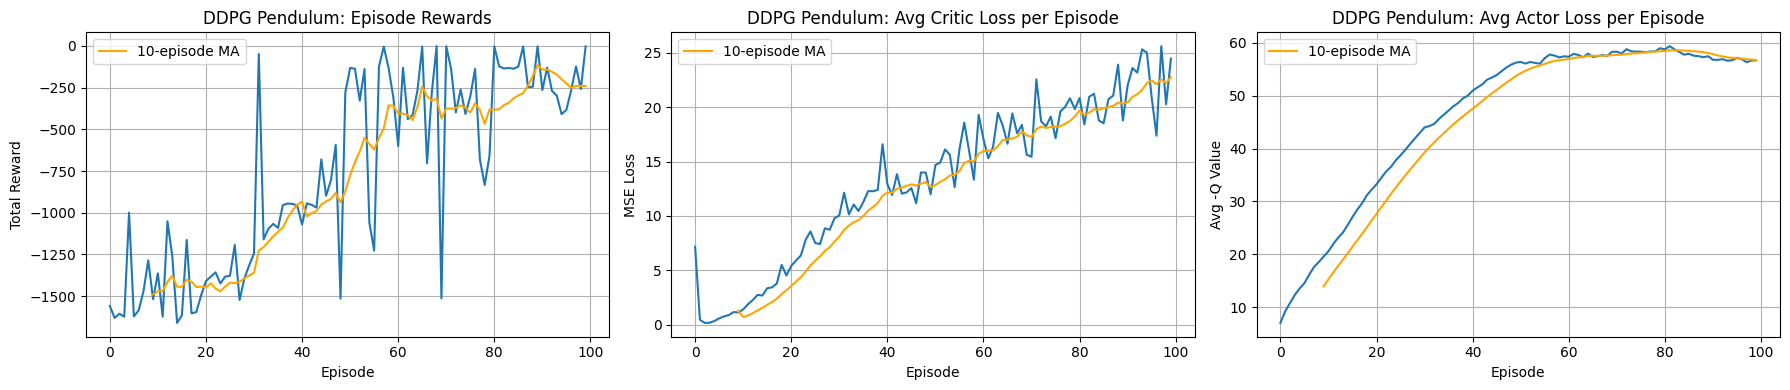

In [12]:
# Plotting results for DDPG on Pendulum-v1
plt.figure(figsize=(18, 4))

# Episode Rewards
plt.subplot(1, 3, 1)
plt.plot(ddpg_episode_rewards)
plt.title('DDPG Pendulum: Episode Rewards')
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.grid(True)
# Add moving average
if len(ddpg_episode_rewards) >= 10:
    rewards_ma_ddpg = np.convolve(ddpg_episode_rewards, np.ones(10)/10, mode='valid')
    plt.plot(np.arange(len(rewards_ma_ddpg)) + 9, rewards_ma_ddpg, label='10-episode MA', color='orange')
    plt.legend()

# Critic Loss
plt.subplot(1, 3, 2)
plt.plot(ddpg_episode_critic_losses)
plt.title('DDPG Pendulum: Avg Critic Loss per Episode')
plt.xlabel('Episode')
plt.ylabel('MSE Loss')
plt.grid(True)
if len(ddpg_episode_critic_losses) >= 10:
    closs_ma_ddpg = np.convolve(ddpg_episode_critic_losses, np.ones(10)/10, mode='valid')
    plt.plot(np.arange(len(closs_ma_ddpg)) + 9, closs_ma_ddpg, label='10-episode MA', color='orange')
    plt.legend()

# Actor Loss
plt.subplot(1, 3, 3)
plt.plot(ddpg_episode_actor_losses)
plt.title('DDPG Pendulum: Avg Actor Loss per Episode')
plt.xlabel('Episode')
plt.ylabel('Avg -Q Value')
plt.grid(True)
if len(ddpg_episode_actor_losses) >= 10:
    aloss_ma_ddpg = np.convolve(ddpg_episode_actor_losses, np.ones(10)/10, mode='valid')
    plt.plot(np.arange(len(aloss_ma_ddpg)) + 9, aloss_ma_ddpg, label='10-episode MA', color='orange')
    plt.legend()

plt.tight_layout()
plt.show()

**Analysis of DDPG Learning Curves (Pendulum):**

1.  **Episode Rewards (Left Plot):**
    The agent shows clear learning, with total rewards trending significantly upwards (becoming less negative) from around -1500 towards -200. This indicates substantial improvement in solving the pendulum swing-up task. High volatility in raw rewards is typical for DDPG on sensitive tasks like Pendulum, but the moving average confirms the positive learning trend.

2.  **Avg Critic Loss per Episode (Middle Plot):**
    The Critic's MSE loss surprisingly *increases* throughout training. While counter-intuitive, this often happens in DDPG as the policy improves and explores higher-value (less negative) state-action pairs. The critic constantly adapts to predict these increasing target Q-values, leading to a rising loss rather than convergence to zero, though it might also hint at some learning instability.

3.  **Avg Actor Loss per Episode (Right Plot):**
    This plot (representing the average Q-value predicted for the actor's actions) shows a strong, smooth upward trend, correlating well with the reward improvement. It signifies the actor is successfully learning actions that the critic evaluates as increasingly better (leading to higher Q-values). The plateau towards the end suggests convergence towards an effective policy.

**Overall Conclusion:**
DDPG successfully learned to improve its performance significantly on the continuous control Pendulum task, pushing rewards towards better values. The actor effectively optimized its policy based on the critic's evaluations. While the increasing critic loss warrants attention (potentially indicating the critic struggles to keep up with the actor or changing value scales), the overall reward trend confirms successful learning, albeit with the volatility often associated with DDPG.

# Analyzing the Learned Policy (Testing)

Visualize the performance of the trained DDPG agent by running it deterministically (no noise) in the environment for a few episodes.

In [13]:
def test_ddpg_agent(actor_net: ActorNetwork, 
                    env_instance: gym.Env, 
                    num_episodes: int = 5, 
                    render: bool = False, # Set to True to visualize
                    seed_offset: int = 1000) -> None:
    """
    Tests the trained DDPG agent deterministically.
    
    Parameters:
    - actor_net: The trained actor network.
    - env_instance: An instance of the environment.
    - num_episodes: Number of test episodes to run.
    - render: If True, attempts to render the environment.
    - seed_offset: Offset for seeding test episodes differently from training.
    """
    if env_instance is None:
        print("Environment not available for testing.")
        return
        
    actor_net.eval() # Set actor to evaluation mode (important!)
    
    print(f"\n--- Testing DDPG Agent ({num_episodes} episodes) ---")
    all_rewards = []
    for i in range(num_episodes):
        state_np, info = env_instance.reset(seed=seed + seed_offset + i) # Different seed for testing
        state = torch.from_numpy(state_np).float().to(device)
        episode_reward = 0
        done = False
        t = 0
        while not done:
            if render:
                try:
                    # Try rendering (might require extra setup depending on environment/system)
                    env_instance.render()
                    time.sleep(0.01) # Slow down rendering slightly
                except Exception as e:
                    print(f"Rendering failed: {e}. Disabling render.")
                    render = False # Disable rendering if it fails
            
            with torch.no_grad():
                # Select action deterministically (no noise)
                action = actor_net(state).cpu().numpy()
            
            # Clipping is still important even in testing
            action_clipped = np.clip(action, env_instance.action_space.low, env_instance.action_space.high)
            
            next_state_np, reward, terminated, truncated, _ = env_instance.step(action_clipped)
            done = terminated or truncated
            state = torch.from_numpy(next_state_np).float().to(device)
            episode_reward += reward
            t += 1
        
        print(f"Test Episode {i+1}: Reward = {episode_reward:.2f}, Length = {t}")
        all_rewards.append(episode_reward)
        if render:
             env_instance.close() # Close the render window

    print(f"--- Testing Complete. Average Reward: {np.mean(all_rewards):.2f} ---")

# Run test episodes (ensure env is still available)
test_ddpg_agent(actor_ddpg, env, num_episodes=3, render=False) # Set render=True if you have display setup


--- Testing DDPG Agent (3 episodes) ---
Test Episode 1: Reward = -130.24, Length = 200
Test Episode 2: Reward = -118.55, Length = 200
Test Episode 3: Reward = -369.77, Length = 200
--- Testing Complete. Average Reward: -206.19 ---


## Common Challenges and Solutions in DDPG

**Challenge: Sensitivity to Hyperparameters**
*   **Problem:** DDPG is known to be quite sensitive to learning rates, target update rate ($	au$), noise parameters, network architecture, and batch size.
   **Solutions**:
    *   **Careful Tuning:** Start with known good values for the environment and tune systematically.
    *   **Smaller $\tau$:** Slower target updates (smaller $\tau$) often increase stability.
    *   **Separate Learning Rates:** Using different (often lower for actor) learning rates for actor and critic can be beneficial.
    *   **Batch Normalization:** Can sometimes help stabilize learning in network layers.

**Challenge: Q-Value Overestimation**
*   **Problem:** The critic can learn to overestimate Q-values, especially when using function approximation. This can lead to the actor learning a suboptimal policy that exploits these overestimations.
   **Solutions**:
    *   **TD3 (Twin Delayed DDPG):** A direct successor that addresses this using clipped double Q-learning (two critics, minimum target), delayed policy updates, and target policy smoothing.
    * **Target Network Usage:** Target networks already help mitigate this to some extent compared to not using them.

**Challenge: Exploration in Continuous Spaces**
*   **Problem:** Simple noise like Gaussian might not be sufficient for exploring complex state-action spaces effectively.
   **Solutions**:
    *   **Correlated Noise (Ornstein-Uhlenbeck):** Used in the original DDPG paper, encourages more consistent exploration trajectories.
    *   **Parameter Space Noise:** Adds noise directly to the actor's parameters instead of actions, potentially leading to more consistent exploration.
    *   **Adaptive Noise:** Adjust noise scale based on performance or distance between actor and target actor parameters.

**Challenge: Slow Learning on Complex Tasks**
*   **Problem:** While sample efficient due to off-policy learning, convergence can still be slow on very hard problems.
   **Solutions**:
    *   **Prioritized Experience Replay (PER):** Sample important transitions more often from the replay buffer.
    *   **TD3/SAC:** Successor algorithms often learn faster and more robustly.
    * **Distributed DDPG (e.g., Ape-X DDPG):** Use multiple actors to collect experience in parallel feeding a central learner.

## Conclusion

Deep Deterministic Policy Gradient (DDPG) successfully extends actor-critic methods to continuous action spaces by learning a deterministic policy and leveraging techniques from DQN like replay buffers and target networks for stable, off-policy learning. Its ability to handle continuous actions made it a foundational algorithm for robotics and continuous control tasks.

While DDPG can be sensitive to hyperparameters and sometimes prone to Q-value overestimation, its core concepts—off-policy actor-critic learning with deterministic policies and target networks—paved the way for more advanced and robust algorithms like TD3 and SAC. Understanding DDPG is essential for tackling continuous control problems in reinforcement learning.